In [1]:
import pandas as pd
from tqdm.auto import tqdm
from util import *
from stationUtil import line_range, get_line
from graph import *

len(subway_graph) == len(interval_time) :  True


/home/tfk/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEMAND_GRAPH_PATH = "../trimmed_data/demand_graph.pickle"
demand = loadPickle(DEMAND_GRAPH_PATH)

In [3]:
demand.keys().__len__()

10972

In [4]:
def od_metric(scode_start, scode_end):
    try:
        return demand[(scode_start, scode_end)] + demand[(scode_end, scode_start)]
    except:
        return 0

In [5]:
# 아무것도 제외 하지 않으면 완행열차와 동일하다.
UNITFACTOR_P1KM_TO_1KM = 1 / 10
UNITFACTOR_1SEC_TO_1HOUR = 1 / 3600
EXCLUDE_STATION = []
g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
g_dist = dist_weight_graph()

sCode_start, sCode_end = 95, 126
calc_total_path_weight(g_time, sCode_start, sCode_end), calc_total_path_weight(
    g_dist, sCode_start, sCode_end
)  # (Second, 0.1km)

(3835, 316)

In [6]:
# 완행열차 Test
[
    (  # 표정속도                           # 실제 표정속도
        calc_line_speed(1, g_dist, g_time),  # 30.7㎞/h
        calc_line_speed(2, g_dist, g_time),  # 32.3㎞/h
        calc_line_speed(3, g_dist, g_time),  # 31.9㎞/h
        calc_line_speed(4, g_dist, g_time),  # 28.8㎞/h
    ),
    (  #Time
        calc_line_spend_time(1,g_time),
        calc_line_spend_time(2,g_time),
        calc_line_spend_time(3,g_time),
        calc_line_spend_time(4,g_time),
    ),
]

[(30.271865121180195,
  32.28571428571429,
  31.63106796116505,
  29.488054607508534),
 (4745, 5040, 2060, 1465)]

In [7]:
from stationUtil import *

subway_graph_index, _ = fn_export_subway_graph(
    loadPickle(PATH_INTER_STATION_SPEND_TIME)
)


def unit_tranfer_flux_metric(scode_start, scode_end, g_dist=g_dist):
    path_dist = (
        calc_total_path_weight(g_dist, scode_start, scode_end) * UNITFACTOR_P1KM_TO_1KM
    )
    path_od = od_metric(scode_start, scode_end)
    return path_dist * path_od


exchange_relation_index = fn_export_exchange_station_index(idx=subway_graph_index)

len(subway_graph) == len(interval_time) :  True


In [8]:
# Calc Flux Metric
flux_metric = []
for target_scode in loadPickle("../trimmed_data/stationNameCode.pickel").values():
    arr = []
    for calc_scode in loadPickle("../trimmed_data/stationNameCode.pickel").values():
        flux = unit_tranfer_flux_metric(target_scode, calc_scode)
        try:
            arr.append(flux)
        except:
            pass
    flux_metric.append([target_scode, sum(arr)])

df = pd.DataFrame(flux_metric, columns=["scode", "flux_metric"])
df_transfer_metric = df.sort_values(by="scode").reset_index(drop=True)

In [9]:
# 역명을 코드로 변환하기 위한 data
station_namecode_table = pd.read_json("../trimmed_data/stationCodeNameLine.json")
station_namecode_table["StationName"] = station_namecode_table["StationName"].apply(
    lambda _X: _X.replace("·", ".").replace("국제금융센터", "국제금융")
)

# 잠재수요특성 불러오가
implicit_metric = pd.read_csv(
    "../trimmed_data/역별_잠재수요특성_합계.csv", encoding="EUC-KR"
)
implicit_metric.head()

,LineCode,StationName,각 역의 잠재수요특성
0,1,괴정,195077.5054
1,1,교대,330461.8518
2,1,구서,117684.0903
3,1,남산,61450.3347
4,1,남포,473685.6213


In [10]:
# Name to Code Convert
replace_relation = {
    r.StationName: int(r.StationCode)
    for r in station_namecode_table.loc[:, ["StationName", "StationCode"]].itertuples()
}
column_rename_relation = {
    "각 역의 잠재수요특성": "implicit_metric",
    "StationName": "scode",
}

df_implicit_metric = implicit_metric.replace(replace_relation)
df_implicit_metric = df_implicit_metric.rename(columns=column_rename_relation)
df_implicit_metric = df_implicit_metric.sort_values(by="scode").reset_index(drop=True)

df_implicit_metric.head()

,LineCode,scode,implicit_metric
0,1,95,53626.31105
1,1,96,91542.13840
2,1,97,154919.42510
3,1,98,217571.13860
4,1,99,220428.80550


In [11]:
df_metric = df_transfer_metric.copy(deep=True)
df_metric["implicit_metric"] = df_implicit_metric["implicit_metric"]
df_metric["LineCode"] = df_metric["scode"].apply(get_line)

df_metric.head()

,scode,flux_metric,implicit_metric,LineCode
0,95,0.0,53626.31105,1
1,96,0.0,91542.13840,1
2,97,0.0,154919.42510,1
3,98,0.0,217571.13860,1
4,99,0.0,220428.80550,1


In [12]:
TARGET_LINE = 2

df_metric_norm = df_metric.copy(deep=True)
df_metric_norm = df_metric_norm[df_metric_norm["LineCode"] == TARGET_LINE]

# Normalize
df_metric_norm.loc[:, "flux_metric":"implicit_metric"] = (
    df_metric_norm.loc[:, "flux_metric":"implicit_metric"]
    / df_metric_norm.loc[:, "flux_metric":"implicit_metric"].max()
)

In [13]:
# Set Condition Matrix
# ~n등급 누적
RANGE_5 = (df_metric_norm.loc[:, "implicit_metric"] <= 0.2) & (
    df_metric_norm.loc[:, "flux_metric"] <= 0.2
)
RANGE_4 = (df_metric_norm.loc[:, "implicit_metric"] <= 0.4) & (
    df_metric_norm.loc[:, "flux_metric"] <= 0.4
)
RANGE_3 = (df_metric_norm.loc[:, "implicit_metric"] <= 0.6) & (
    df_metric_norm.loc[:, "flux_metric"] <= 0.6
)
RANGE_2 = (df_metric_norm.loc[:, "implicit_metric"] <= 0.8) & (
    df_metric_norm.loc[:, "flux_metric"] <= 0.8
)
RANGE_1 = (df_metric_norm.loc[:, "implicit_metric"] <= 1.0) & (
    df_metric_norm.loc[:, "flux_metric"] <= 1.0
)

# n등급 only
GRADE_5 = RANGE_5
GRADE_4 = RANGE_4 & -RANGE_5
GRADE_3 = RANGE_3 & -RANGE_4
GRADE_2 = RANGE_2 & -RANGE_3
GRADE_1 = RANGE_1 & -RANGE_2

In [16]:
g1 = df_metric_norm[GRADE_1]["scode"].to_list()
g2 = df_metric_norm[GRADE_2]["scode"].to_list()
g3 = df_metric_norm[GRADE_3]["scode"].to_list()
g4 = df_metric_norm[GRADE_4]["scode"].to_list()
g5 = df_metric_norm[GRADE_5]["scode"].to_list()

TO_GRADE = [-1, [*g2, *g3, *g4, *g5], [*g3, *g4, *g5], [*g4, *g5], [*g5], []]


def get_speed(exclude=TO_GRADE[5]):
    EXCLUDE_STATION = exclude
    g_dist = dist_weight_graph()
    g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
    return calc_line_speed(TARGET_LINE, g_dist, g_time)

def get_time(exclude=TO_GRADE[5]):
    EXCLUDE_STATION = exclude
    g_time = time_weight_graph(exclude_list=EXCLUDE_STATION)
    return calc_line_spend_time(TARGET_LINE, g_time)


38.019,  760 | [215, 216, 219, 227]
37.236,  670 | [201, 206, 212, 214, 217]
36.000,  520 | [202, 203, 204, 208, 213, 235, 240, 241, 243]
32.806,   80 | [205, 207, 209, 210, 211, 218, 220, 221, 222, 223, 224, 225, 228, 229, 230, 231, 233, 234, 236, 239, 242]
32.286,    0 | [226, 232, 237, 238]



<Axes: xlabel='flux_metric', ylabel='implicit_metric'>

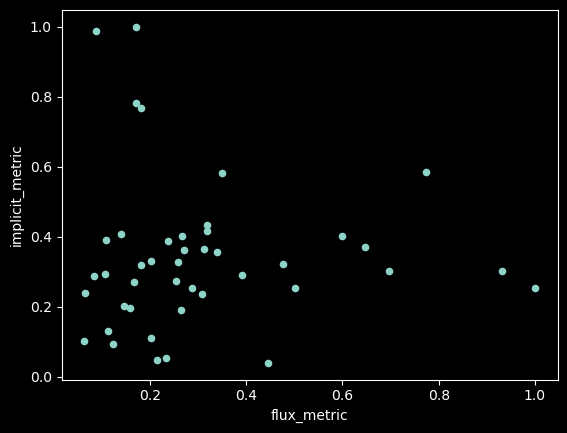

In [19]:
print(
    "{:#.5},{:#5} | {}\n{:#.5},{:#5} | {}\n{:#.5},{:#5} | {}\n{:#.5},{:#5} | {}\n{:#.5},{:#5} | {}\n".format(
        get_speed(TO_GRADE[1]),get_time(TO_GRADE[5])-get_time(TO_GRADE[1]),g1,
        get_speed(TO_GRADE[2]),get_time(TO_GRADE[5])-get_time(TO_GRADE[2]),g2,
        get_speed(TO_GRADE[3]),get_time(TO_GRADE[5])-get_time(TO_GRADE[3]),g3,
        get_speed(TO_GRADE[4]),get_time(TO_GRADE[5])-get_time(TO_GRADE[4]),g4,
        get_speed(TO_GRADE[5]),get_time(TO_GRADE[5])-get_time(TO_GRADE[5]),g5
    )
)
df_metric_norm.plot.scatter(x="flux_metric", y="implicit_metric")